# 📁 11_ Train a Model (ResNet18 Fine-Tuning)_Noise aug.ipynb

"""
Train the ResNet-18 model on the training data augmented with background noise,
then evaluate on test data with:
- Confusion Matrix
- Seaborn Heatmap
Data Format: Mel Spectrograms (RGB Images)
"""

In [1]:
# 📦 Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [14]:
# 📂 Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import random
import numpy as np
import os

def set_seed(seed=42):
    print(f"📌 Setting seed: {seed}")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


📌 Setting seed: 42


In [4]:
class MelSpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        base_name = os.path.splitext(row["filename"])[0]
        image_path = os.path.join(self.image_dir, base_name + ".png")
        image = Image.open(image_path).convert("RGB")
        label = int(row["label"])

        if self.transform:
            image = self.transform(image)

        return image, label


In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # mean
                         [0.229, 0.224, 0.225])   # std
])


train_csv = "/content/drive/MyDrive/final_csv/train_final_noised.csv"
train_dir = "/content/drive/MyDrive/melspec_noised"
test_csv = "/content/drive/MyDrive/final_csv/test_final.csv"
test_dir = "/content/drive/MyDrive/final_melspec_test"


train_dataset = MelSpectrogramDataset(train_csv, train_dir, transform=transform)
test_dataset  = MelSpectrogramDataset(test_csv, test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = "resnet"  # یا "mobilenet" resnet

if model_type == "resnet":
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)
    for param in model.fc.parameters():
        param.requires_grad = True

elif model_type == "mobilenet":
    model = mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 4)
    for param in model.classifier[1].parameters():
        param.requires_grad = True

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

num_epochs = 30
best_acc = 0
patience = 4
counter = 0


📘 Epoch 1 | Loss: 4.1710 | Train Acc: 0.6731
🧪 Test Acc: 0.3056
📘 Epoch 2 | Loss: 3.7257 | Train Acc: 0.7788
🧪 Test Acc: 0.2778
📘 Epoch 3 | Loss: 3.4458 | Train Acc: 0.7788
🧪 Test Acc: 0.2500
📘 Epoch 4 | Loss: 3.4303 | Train Acc: 0.7788
🧪 Test Acc: 0.3333
📘 Epoch 5 | Loss: 3.3275 | Train Acc: 0.8173
🧪 Test Acc: 0.4167
📘 Epoch 6 | Loss: 3.0733 | Train Acc: 0.8173
🧪 Test Acc: 0.3889
📘 Epoch 7 | Loss: 2.9515 | Train Acc: 0.8846
🧪 Test Acc: 0.4167
📘 Epoch 8 | Loss: 2.7769 | Train Acc: 0.8942
🧪 Test Acc: 0.3889
📘 Epoch 9 | Loss: 2.9519 | Train Acc: 0.8269
🧪 Test Acc: 0.3611
🛑 Early stopping triggered.


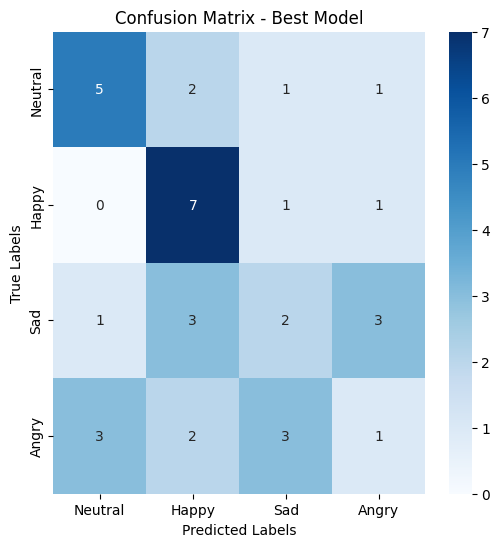

In [21]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print(f"📘 Epoch {epoch+1} | Loss: {running_loss:.4f} | Train Acc: {train_acc:.4f}")

    # 🔎 Evaluation
    model.eval()
    correct_test = 0
    total_test = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = correct_test / total_test
    print(f"🧪 Test Acc: {test_acc:.4f}")

    # ⛔ Early Stopping
    if test_acc > best_acc:
        best_acc = test_acc
        counter = 0
        torch.save(model.state_dict(), f"best_model_{model_type}.pth")
        # Save best preds and labels
        best_preds = all_preds
        best_labels = all_labels
    else:
        counter += 1
        if counter >= patience:
            print("🛑 Early stopping triggered.")
            break

# 📊 Confusion Matrix and Heatmap after training
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(best_labels, best_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Happy', 'Sad', 'Angry'],
            yticklabels=['Neutral', 'Happy', 'Sad', 'Angry'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Best Model')
plt.show()

